# Personnel Turnover Prediction - Decision Tree & Random Forest

## Introduction

One out of every three employees who meet these three characteristics: a company with little involvement, little interaction with colleagues and a low happiness index, will leave the company in a matter of weeks. On the contrary, those employees who are participative, have a happiness index at or above average and work in a company involved in the well-being of the organization remain in their jobs in 99.5% of the cases.

Attracting and retaining talent is one of the keys to the present and future for many companies. A high turnover rate not only increases human resources costs, which can reach up to 150% of the annual salary per employee replaced, but also has social costs, as turnover usually means lower salaries, a decrease in productivity per employee and, logically, a workforce that is less loyal to their companies.

The cost of high employee turnover is one of the variables that companies often pay less attention to, and yet it is a very important fact, because companies invest time and resources in training workers, so losing them means losing that investment.

## Objetive

Since personnel its one of the most valuable resources of a company, it is advisable to develop a model that allows organizations to predict when a worker is going to leave their job, so that companies could avoid that turnover and with it the costs associated with a change of employee.

We aim to analyze several factors of a dataset of around 15,000 employees through the Happyforce platform, which takes the pulse of the organization by measuring aspects such as employee well-being, personnel engagement, management quality and other company factors and use machine learning models to predict future personnel turnover in order to find strategies like bonuses or incentives that may reduce personnel turnover within the organization or bussineses.

In [14]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas_profiling
import yellowbrick
from yellowbrick import ClassBalance
from __future__ import print_function
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,8)
warnings.simplefilter('ignore')
%matplotlib inline

df = pd.read_csv('Personnel_data.csv')
df.reset_index(inplace=True)
df.columns = ['satisfaction_level', 'last_evalation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'work_accident', 'quit', 'promotion_last_5years', 'department', 'salary']
df

,satisfaction_level,last_evalation,number_project,average_monthly_hours,time_spend_company,work_accident,quit,promotion_last_5years,department,salary
0,0.40,0.56,2,149,3,0,1,0,accounting,low
1,0.90,0.97,4,258,5,0,1,0,accounting,low
2,0.37,0.46,2,158,3,0,1,0,hr,low
3,0.44,0.54,2,149,3,0,1,0,hr,low
4,0.85,0.95,5,236,5,0,1,0,hr,low
...,...,...,...,...,...,...,...,...,...,...
14770,0.40,0.57,2,151,3,0,1,0,support,low
14771,0.37,0.48,2,160,3,0,1,0,support,low
14772,0.37,0.53,2,143,3,0,1,0,support,low
14773,0.11,0.96,6,280,4,0,1,0,support,low


## Exploratory Data Analysis

One good alternative to start exploring the data is pandas profiling that wraps around a dataframe and generates a report with descriptive statistics, distribution plots, interactions and correlations between our variables. Addicionaly we want to use the cross-tabulation to plot results and show the frequency with which certain groups of data appear togueter. We want to know how employes of diferent salary brackets quit or stay in the company to get a better understanding of the situation. Also plotting by department can be informative.

In [2]:
df.profile_report(title='Report')

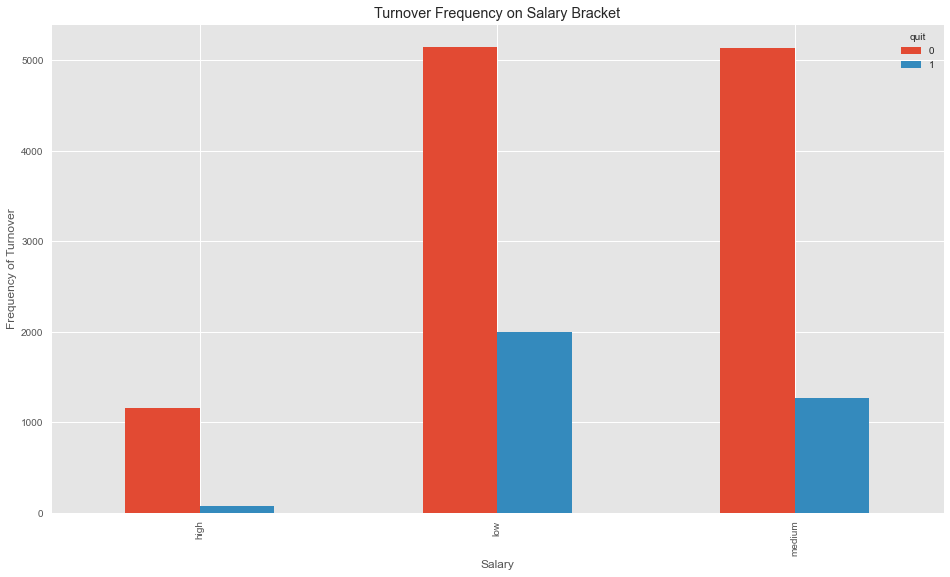

In [3]:
plt.rcParams["figure.figsize"] = [16,9]
pd.crosstab(df.salary, df.quit).plot(kind='bar')
plt.title('Turnover Frequency on Salary Bracket')
plt.xlabel('Salary')
plt.ylabel('Frequency of Turnover')
plt.show()

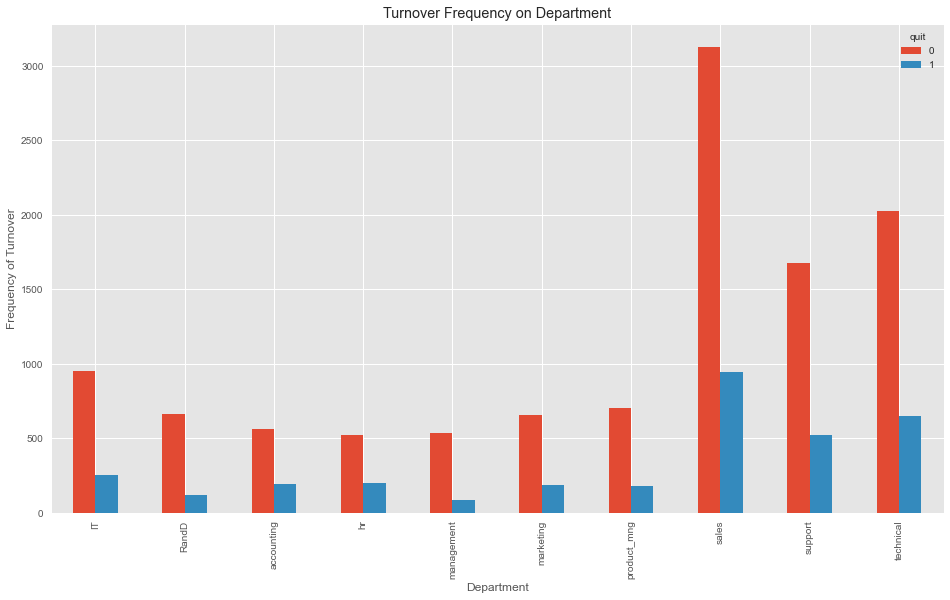

In [4]:
plt.rcParams["figure.figsize"] = [16,9]
pd.crosstab(df.department, df.quit).plot(kind='bar')
plt.title('Turnover Frequency on Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.show()

Now that we identified our categorical variables: salary and department, these need to be converted into dummy variables before they can be used for a scikit learn model.

In [5]:
cat_vars = ['department', 'salary']
for var in cat_vars:
    cat_list=pd.get_dummies(df[var], prefix=var)
    df=df.join(cat_list)
df.head()

,satisfaction_level,last_evalation,number_project,average_monthly_hours,time_spend_company,work_accident,quit,promotion_last_5years,department,salary,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.40,0.56,2,149,3,0,1,0,accounting,low,...,0,0,0,0,0,0,0,0,1,0
1,0.90,0.97,4,258,5,0,1,0,accounting,low,...,0,0,0,0,0,0,0,0,1,0
2,0.37,0.46,2,158,3,0,1,0,hr,low,...,1,0,0,0,0,0,0,0,1,0
3,0.44,0.54,2,149,3,0,1,0,hr,low,...,1,0,0,0,0,0,0,0,1,0
4,0.85,0.95,5,236,5,0,1,0,hr,low,...,1,0,0,0,0,0,0,0,1,0


One frequent issue with binary classification problems is that models can fail even if you created a good train-test split, choose the rigth features, optimize the right parameters due to a class imbalance. If you take a look to  the distribution of the classes in our target, you can be abe to come up with efective strategies to mitigate an imbalance if one exist such as oversampling minority class.

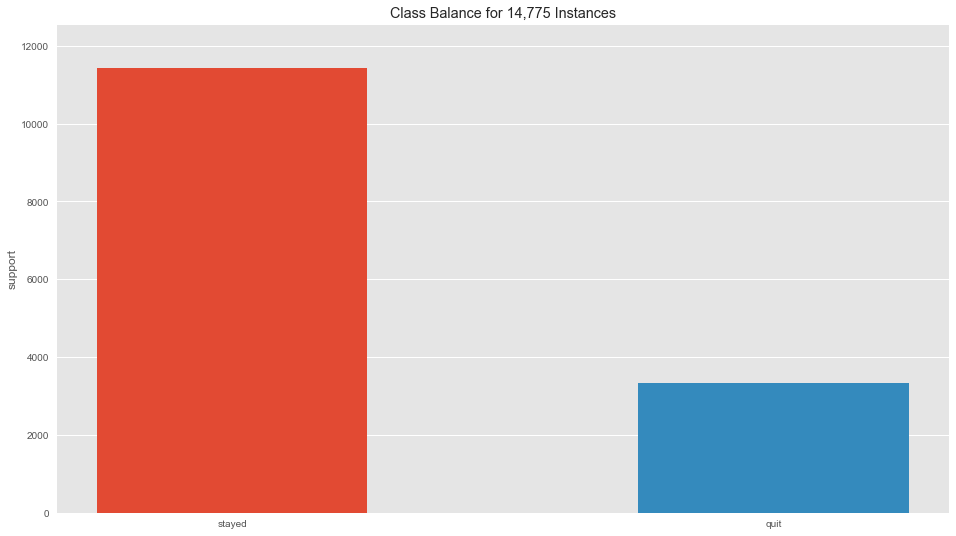

In [6]:
df.drop(columns=['department', 'salary'], axis=1, inplace=True)
visualizer = ClassBalance(labels=['stayed', 'quit']).fit(df.quit)
visualizer.show();

As expected we have a class imbalance problem. There are more numbre of employees that stayed on the company than leave.What we can do is make sure that apply stratified sampling while gettin our train and test sets as well as in our validation data.

## Training and Test Split

Creating training and test sets for validation is very simple using a scikit learn split funtion. First we need to separate uor data into our feature matrix and target vector.

In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz 
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
from IPython.display import Image
from sklearn.model_selection import train_test_split
from subprocess import call
import matplotlib.image as mpimg
import ipywidgets

X = df.loc[:, df.columns != 'quit']
y = df.quit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

## Decision Tree and Random Forest Interactive Models

Once that we have created our training and validation sets we can move on to creating our decision tree and random forest classifiers as well as using the jupyter interactive widgets to be able to have interactive controls and change our model parameters like criterion, split and even sliders to change depth or the minimum leaves requiered.

In [8]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

@interact
def plot_tree(crit=['gini', 'entropy'],
              split=['best', 'random'],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = DecisionTreeClassifier(random_state=0,
                                      criterion=crit,
                                      splitter=split,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf)
    estimator.fit(X_train, y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree Accuracy {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    graph = Source(tree.export_graphviz(estimator, out_file=None,
                                       feature_names=X_train.columns,
                                       class_names=['stayed', 'quit'],
                                       filled=True))
    display(Image(data=graph.pipe(format='png')))

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

One problem with decision trees is that they have low bias but high variance which is says they are suceptible and prone to overfitting on the training set. We are going to do the similar procedure to overcome the variance problem by creating a random forest model that creates a better general result.

In [9]:
@interact
def plot_tree(crit=['gini', 'entropy'],
              bootstrap=['True', 'False'],
              depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
              forests=IntSlider(min=1,max=200,value=100, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = RandomForestClassifier(random_state=1,
                                      criterion=crit,
                                      bootstrap=bootstrap,
                                      n_estimators=forests,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf,
                                      n_jobs=-1,
                                      verbose=False)
    estimator.fit(X_train, y_train)
    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Random Forest Test Accuracy {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print('\Visualizing Tree: ', 0)
    graph = Source(tree.export_graphviz(num_tree, out_file=None,
                                       feature_names=X_train.columns,
                                       class_names=['stayed', 'quit'],
                                       filled=True))
    display(Image(data=graph.pipe(format='png')))

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

## Feature Importance and Evaluation Metrics

Since we already have our models, the next step is to take a look to the features this models consider most important and plot them visualy to get a better understanding.

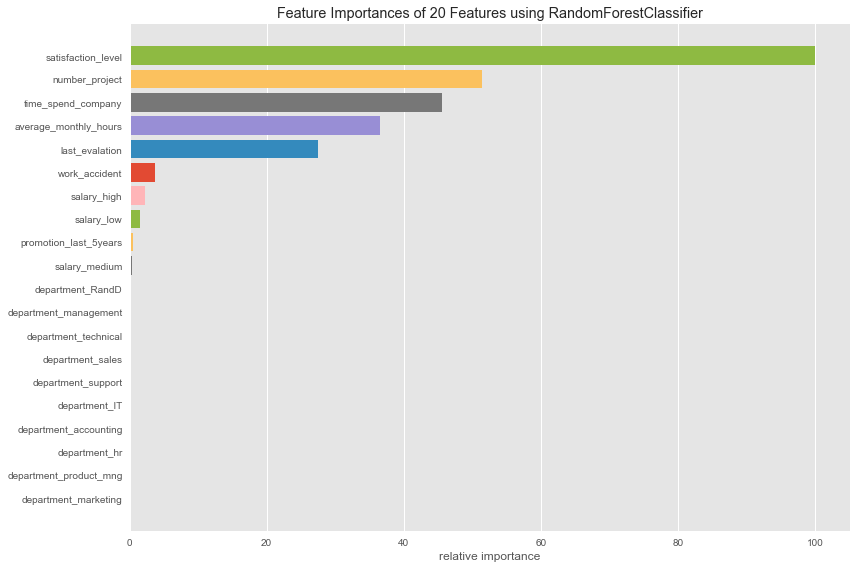

In [10]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')

rand_forest =  RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
                             max_depth=5, max_features='auto', max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                             oob_score=False, random_state=1,verbose=False,
                             warm_start=False)
viz = FeatureImportances(rand_forest)
viz.fit(X_train, y_train)
viz.show();

As you may see  on the x axis we have the reltive importance score and on the y axis the individual features. The random forest weights the different features acording to its importance. In this case the top 5 features way above of the other ones for the prediction process.

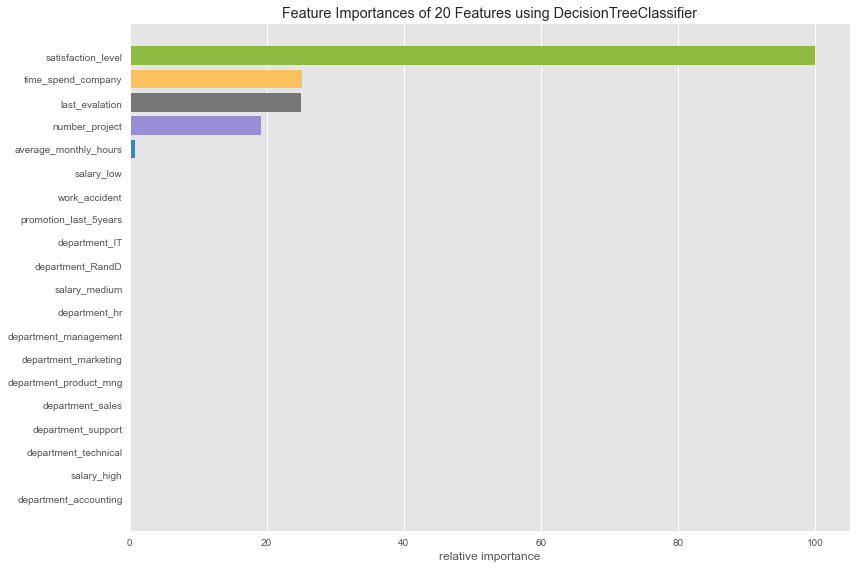

In [11]:
deci_tree =  DecisionTreeClassifier(class_weight=None, criterion='gini',
                             max_depth=3, max_features=None, max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
                             splitter='best')
viz = FeatureImportances(deci_tree)
viz.fit(X_train, y_train)
viz.show();

You will notice that both models have similar important features such as time spend at the company, number of projects and average monthly ours, but the most important is the satisfaction level in both cases. 

The final step is to evaluate the ROC metric on both models and see how the curves behave.

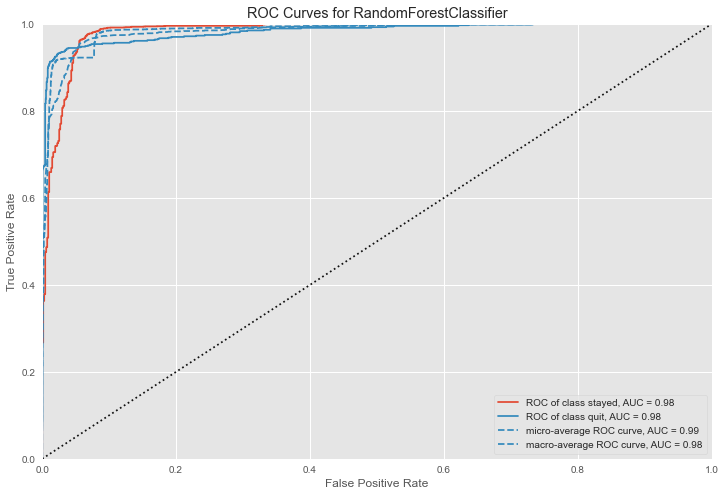

In [12]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rand_forest, classes=['stayed', 'quit'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

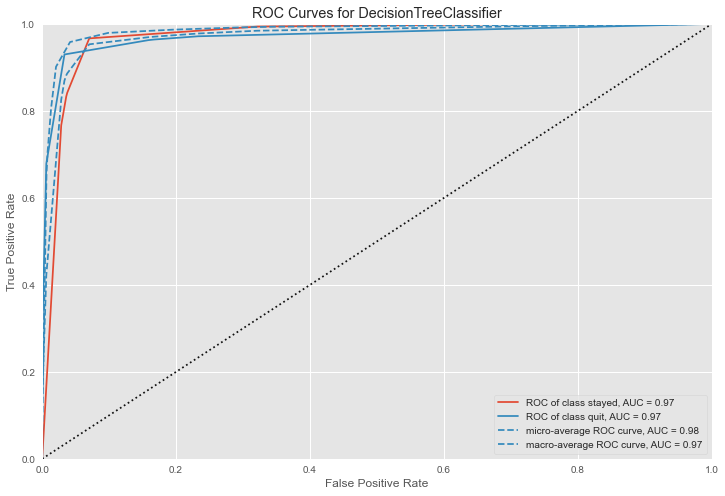

In [13]:
visualizer = ROCAUC(deci_tree, classes=['stayed', 'quit'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

For evaluating the modelsBy looking at the area under the curve and the ROC curve you want that them go as close as possible to the left corner. As you can visualice both classifiers random forest and decision tree perform similar, however the random forest model performs slightly better, so its a good option to go ahead with it. 

## Conclussion

In an increasingly complex world, with more interactions between users and systems and a greater amount of information, machine learning techniques are becoming more and more relevant, as they help us to generalize how the different variables in a process are related and, consequently, to reduce the margin of error in the estimation of a result.

These tools can be applied to those areas where a large amount of data is generated and, above all, where there are repetitive activities or behaviors that can be optimized through algorithmic techniques.

Employee participation and happiness is just as important as the company's involvement in achieving this participation and raising the happiness index. A company with wellness plans for its employees will have a much lower turnover rate than one that does not and may help to save millions of dollars to large companies.